# Import

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 20

# Read Data

In [3]:
db_conf = pd.read_parquet("db_conf.parquet")
db_conf.index = db_conf["db_idx"]
db_conf.drop(columns=["Unnamed: 0", "db_idx"], inplace=True)
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
# db_conf.drop(columns=["CONF", "CONFCl", "CONFClBr", "CONFClBrI"], inplace=True)
db_conf = db_conf.reset_index(drop=True)

In [4]:
na_ind = db_conf[db_conf.iloc[:,4:-1].isna().all(axis=1)].index

In [5]:
db_conf = db_conf.drop(index=na_ind)
db_conf = db_conf.reset_index(drop=True)

# Labels Encoding

In [6]:
from sklearn import preprocessing

In [7]:
le = preprocessing.LabelEncoder()
le.fit(["nB", "B"])
db_conf["class_encoded"] = le.transform(db_conf["Experimental BCF class"])

In [8]:
db_conf["class_encoded"] = db_conf["class_encoded"].replace({1:0, 0:1})

In [9]:
db_conf

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,FQD_9,mol,class_encoded
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",[32107],<rdkit.Chem.rdchem.Mol object at 0x7f0027be3d60>,0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]","[31844, 33001, 33006]",<rdkit.Chem.rdchem.Mol object at 0x7f0027be3dc0>,1
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],[123245],<rdkit.Chem.rdchem.Mol object at 0x7f0027c62ce0>,0
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],None,<rdkit.Chem.rdchem.Mol object at 0x7f0027c62bc0>,0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],[131914],<rdkit.Chem.rdchem.Mol object at 0x7f0027c62b60>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",[145115],<rdkit.Chem.rdchem.Mol object at 0x7f0027c83280>,0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",[137748],<rdkit.Chem.rdchem.Mol object at 0x7f0027c832e0>,1
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...","[26263, 26273, 28867, 32083, 32170, 32193, 322...",<rdkit.Chem.rdchem.Mol object at 0x7f0027c83340>,0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]","[25503, 26283, 32992]",<rdkit.Chem.rdchem.Mol object at 0x7f0027c833a0>,0


# RDKit descriptors

In [10]:
descriptors_names = [ x[0] for x in Descriptors._descList ] #list of all RDKit Descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator( descriptors_names )
descriptors = pd.DataFrame()
maccs_keys = pd.DataFrame()
morgan_fp = pd.DataFrame()
for mol in db_conf["mol"]:
    descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
    maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
    fp_vect = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, fp_vect)
    morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
cols_rdkit = descriptors_names + [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]
cols = list(db_conf.columns) + cols_rdkit
dat3 = pd.concat([db_conf.reset_index(drop=True), descriptors.reset_index(drop=True), maccs_keys.reset_index(drop=True), morgan_fp.reset_index(drop=True)], axis=1)
dat3.columns = cols


/tmp/ipykernel_4171/3507132588.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/tmp/ipykernel_4171/3507132588.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
/tmp/ipykernel_4171/3507132588.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
/tmp/ipykernel_4171/3507132588.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/tmp/

In [11]:
bin_cols = [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]

In [12]:
dat3

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
x = dat3.iloc[:, 13:]
y = dat3["class_encoded"]

# OOB dataset creation

In [15]:
oob_idx = np.loadtxt("oob_idx").astype(int)
train_idx = np.loadtxt("train_idx").astype(int)

In [16]:
res_x, res_y = x.loc[list(train_idx.astype(int))], y.loc[list(train_idx.astype(int))]

In [17]:
oob_x, oob_y = x.loc[list(oob_idx)], y.loc[list(oob_idx)]

In [18]:
x, y = res_x, res_y

In [19]:
y.value_counts()

0    409
1    117
Name: class_encoded, dtype: int64

# Modelling

# Pipeline creation

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=0.95)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import lightgbm as lgb

In [28]:
scor_dict = {"algorithm": [],
            "balanced_accuracy": [],
            "f1 score": []}

In [29]:
x

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
586,12.557380,-0.379905,12.557380,0.261309,0.544126,380.554,348.298,380.213364,146,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
579,10.047593,-0.555833,10.047593,0.088704,0.470728,139.110,134.070,139.026943,52,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305,5.734733,-0.492748,5.734733,0.492748,0.573378,270.372,248.196,270.161980,106,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,12.246667,-0.471568,12.246667,0.030495,0.832966,271.360,250.192,271.157229,106,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,10.362722,-1.010586,10.362722,0.138333,0.740184,191.013,186.981,189.958835,58,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,8.603395,0.056111,8.603395,0.056111,0.634531,142.585,135.529,142.018543,48,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,4.505307,0.983673,4.505307,0.983673,0.583439,293.414,270.230,293.189198,114,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
534,12.369822,-0.220000,12.369822,0.104074,0.806147,239.318,222.182,239.131014,92,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
817,5.869608,0.189389,5.869608,0.189389,0.709080,306.409,284.233,306.173213,118,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from sklearn.model_selection import StratifiedKFold

def my_score(model, n_folds, scoring_callable, X, Y):
    scores = [],[]
    cv = StratifiedKFold(n_folds)
    oversampler = RandomOverSampler(random_state=1)
    preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
            ("pca_cont_data", pca)
        ]),
                                     descriptors_names)], remainder="passthrough")

    for train_index, validation_index in cv.split(X, Y):
        x, y = X.iloc[train_index], Y.iloc[train_index]
        xx, yy = oversampler.fit_resample(x, y)
        xx = preprocessor.fit_transform(xx)
        model.fit(xx, yy)
        x_val = X.iloc[validation_index]
        x_val = preprocessor.transform(x_val)
        score_bac = scoring_callable[0](Y.iloc[validation_index], model.predict(x_val))
        score_f = scoring_callable[1](Y.iloc[validation_index], model.predict(x_val))
        
        print(f"bac: {score_bac}, f1: {score_f}")
        scores[0].append(score_bac)
        scores[1].append(score_f)
    
    return scores

### LogClf

In [56]:
scor_dict["algorithm"].extend(["Logistic Regression"]*5)

In [57]:
reg = LogisticRegression(max_iter=100000)

In [58]:
scores = my_score(reg, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7931910569105691, f1: 0.6666666666666667
bac: 0.8942901234567902, f1: 0.8076923076923077
bac: 0.8146871686108166, f1: 0.693877551020408
bac: 0.7120890774125133, f1: 0.5581395348837209
bac: 0.8016967126193001, f1: 0.7142857142857143


In [59]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [60]:
scor_dict["f1 score"].extend(list(scores[1]))

### Rand Forest

In [61]:
scor_dict["algorithm"].extend(["Random Forest"]*5)

In [62]:
clf = RandomForestClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state=1
)

In [63]:
scores = my_score(clf, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7393292682926829, f1: 0.5882352941176471
bac: 0.8649691358024691, f1: 0.7916666666666666
bac: 0.8390774125132555, f1: 0.7555555555555555
bac: 0.7799575821845175, f1: 0.6829268292682927
bac: 0.7486744432661718, f1: 0.6486486486486486


In [64]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [65]:
scor_dict["f1 score"].extend(list(scores[1]))

### Grad Boosting

In [66]:
scor_dict["algorithm"].extend(["Gradient Boosting"]*5)

In [67]:
gbc = GradientBoostingClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state = 1,
)

In [68]:
scores = my_score(gbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7627032520325203, f1: 0.6071428571428571
bac: 0.867283950617284, f1: 0.7692307692307692
bac: 0.8390774125132555, f1: 0.7555555555555555
bac: 0.718186638388123, f1: 0.5714285714285715
bac: 0.7364793213149523, f1: 0.6153846153846153


In [69]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [70]:
scor_dict["f1 score"].extend(list(scores[1]))

### KNN

In [71]:
scor_dict["algorithm"].extend(["KNN"]*5)

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
knc = KNeighborsClassifier()

In [74]:
scores = my_score(knc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8023373983739838, f1: 0.6052631578947368
bac: 0.8449074074074074, f1: 0.7000000000000001
bac: 0.8337751855779427, f1: 0.6909090909090908
bac: 0.7441675503711559, f1: 0.5714285714285715
bac: 0.8242311770943797, f1: 0.6923076923076923


In [75]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [76]:
scor_dict["f1 score"].extend(list(scores[1]))

### SVC

In [77]:
scor_dict["algorithm"].extend(["SVC"]*5)

In [78]:
from sklearn.svm import SVC

In [79]:
svc = SVC(kernel="poly", degree=4)

In [80]:
scores = my_score(svc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8023373983739838, f1: 0.6052631578947368
bac: 0.7893518518518519, f1: 0.608695652173913
bac: 0.8677094379639448, f1: 0.7407407407407407
bac: 0.7998409331919406, f1: 0.6428571428571429
bac: 0.7895015906680807, f1: 0.6818181818181819


In [81]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [82]:
scor_dict["f1 score"].extend(list(scores[1]))

### XGBoost

In [83]:
scor_dict["algorithm"].extend(["XGBoost"]*5)

In [84]:
xgbc = xgb.XGBClassifier(n_estimators=1000, random_state=1)

In [85]:
scores = my_score(xgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.804369918699187, f1: 0.6551724137931034
bac: 0.9104938271604939, f1: 0.888888888888889
bac: 0.8051431601272534, f1: 0.6956521739130435
bac: 0.752120890774125, f1: 0.6341463414634146
bac: 0.6990986214209968, f1: 0.5555555555555555


In [86]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [87]:
scor_dict["f1 score"].extend(list(scores[1]))

### Light GBM

In [88]:
scor_dict["algorithm"].extend(["Light GBM"]*5)

In [89]:
lgbc = lgb.LGBMClassifier(n_estimators=1000, random_state=1)

In [90]:
scores = my_score(lgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7723577235772358, f1: 0.64
bac: 0.8356481481481481, f1: 0.7727272727272727
bac: 0.8390774125132555, f1: 0.7555555555555555
bac: 0.7303817603393425, f1: 0.6
bac: 0.6834570519618239, f1: 0.5294117647058824


In [91]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [92]:
scor_dict["f1 score"].extend(list(scores[1]))

### Scores vis

In [93]:
scors = pd.DataFrame(scor_dict)
scors

,algorithm,balanced_accuracy,f1 score
0,Logistic Regression,0.793191,0.666667
1,Logistic Regression,0.894290,0.807692
2,Logistic Regression,0.814687,0.693878
3,Logistic Regression,0.712089,0.558140
4,Logistic Regression,0.801697,0.714286
5,Random Forest,0.739329,0.588235
6,Random Forest,0.864969,0.791667
7,Random Forest,0.839077,0.755556
8,Random Forest,0.779958,0.682927
9,Random Forest,0.748674,0.648649


In [94]:
scors.to_csv("scors_rdkit_pca.csv")

In [95]:
scors.groupby(["algorithm"]).mean().to_csv("groupby_rdkit_pca.csv")

In [96]:
scors.groupby(["algorithm"]).mean()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.784746,0.663748
KNN,0.809884,0.651982
Light GBM,0.772184,0.659539
Logistic Regression,0.803191,0.688132
Random Forest,0.794402,0.693407
SVC,0.809748,0.655875
XGBoost,0.794245,0.685883


In [97]:
scors.groupby(["algorithm"]).median()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.762703,0.615385
KNN,0.824231,0.690909
Light GBM,0.772358,0.640000
Logistic Regression,0.801697,0.693878
Random Forest,0.779958,0.682927
SVC,0.799841,0.642857
XGBoost,0.804370,0.655172


In [98]:
melted = scors.melt(id_vars="algorithm", var_name="metric")
melted

,algorithm,metric,value
0,Logistic Regression,balanced_accuracy,0.793191
1,Logistic Regression,balanced_accuracy,0.894290
2,Logistic Regression,balanced_accuracy,0.814687
3,Logistic Regression,balanced_accuracy,0.712089
4,Logistic Regression,balanced_accuracy,0.801697
...,...,...,...
65,Light GBM,f1 score,0.640000
66,Light GBM,f1 score,0.772727
67,Light GBM,f1 score,0.755556
68,Light GBM,f1 score,0.600000


In [99]:
melted.groupby(by=["algorithm","metric"]).apply(lambda x: np.percentile(x, [75, 50, 25]).sum()/3)

algorithm            metric           
Gradient Boosting    balanced_accuracy    0.779420
                     f1 score             0.659361
KNN                  balanced_accuracy    0.820115
                     f1 score             0.662827
Light GBM            balanced_accuracy    0.779463
                     f1 score             0.665185
Logistic Regression  balanced_accuracy    0.803192
                     f1 score             0.691610
Random Forest        balanced_accuracy    0.789236
                     f1 score             0.695710
SVC                  balanced_accuracy    0.797227
                     f1 score             0.644457
XGBoost              balanced_accuracy    0.787211
                     f1 score             0.661657
dtype: float64

<AxesSubplot:xlabel='algorithm', ylabel='value'>

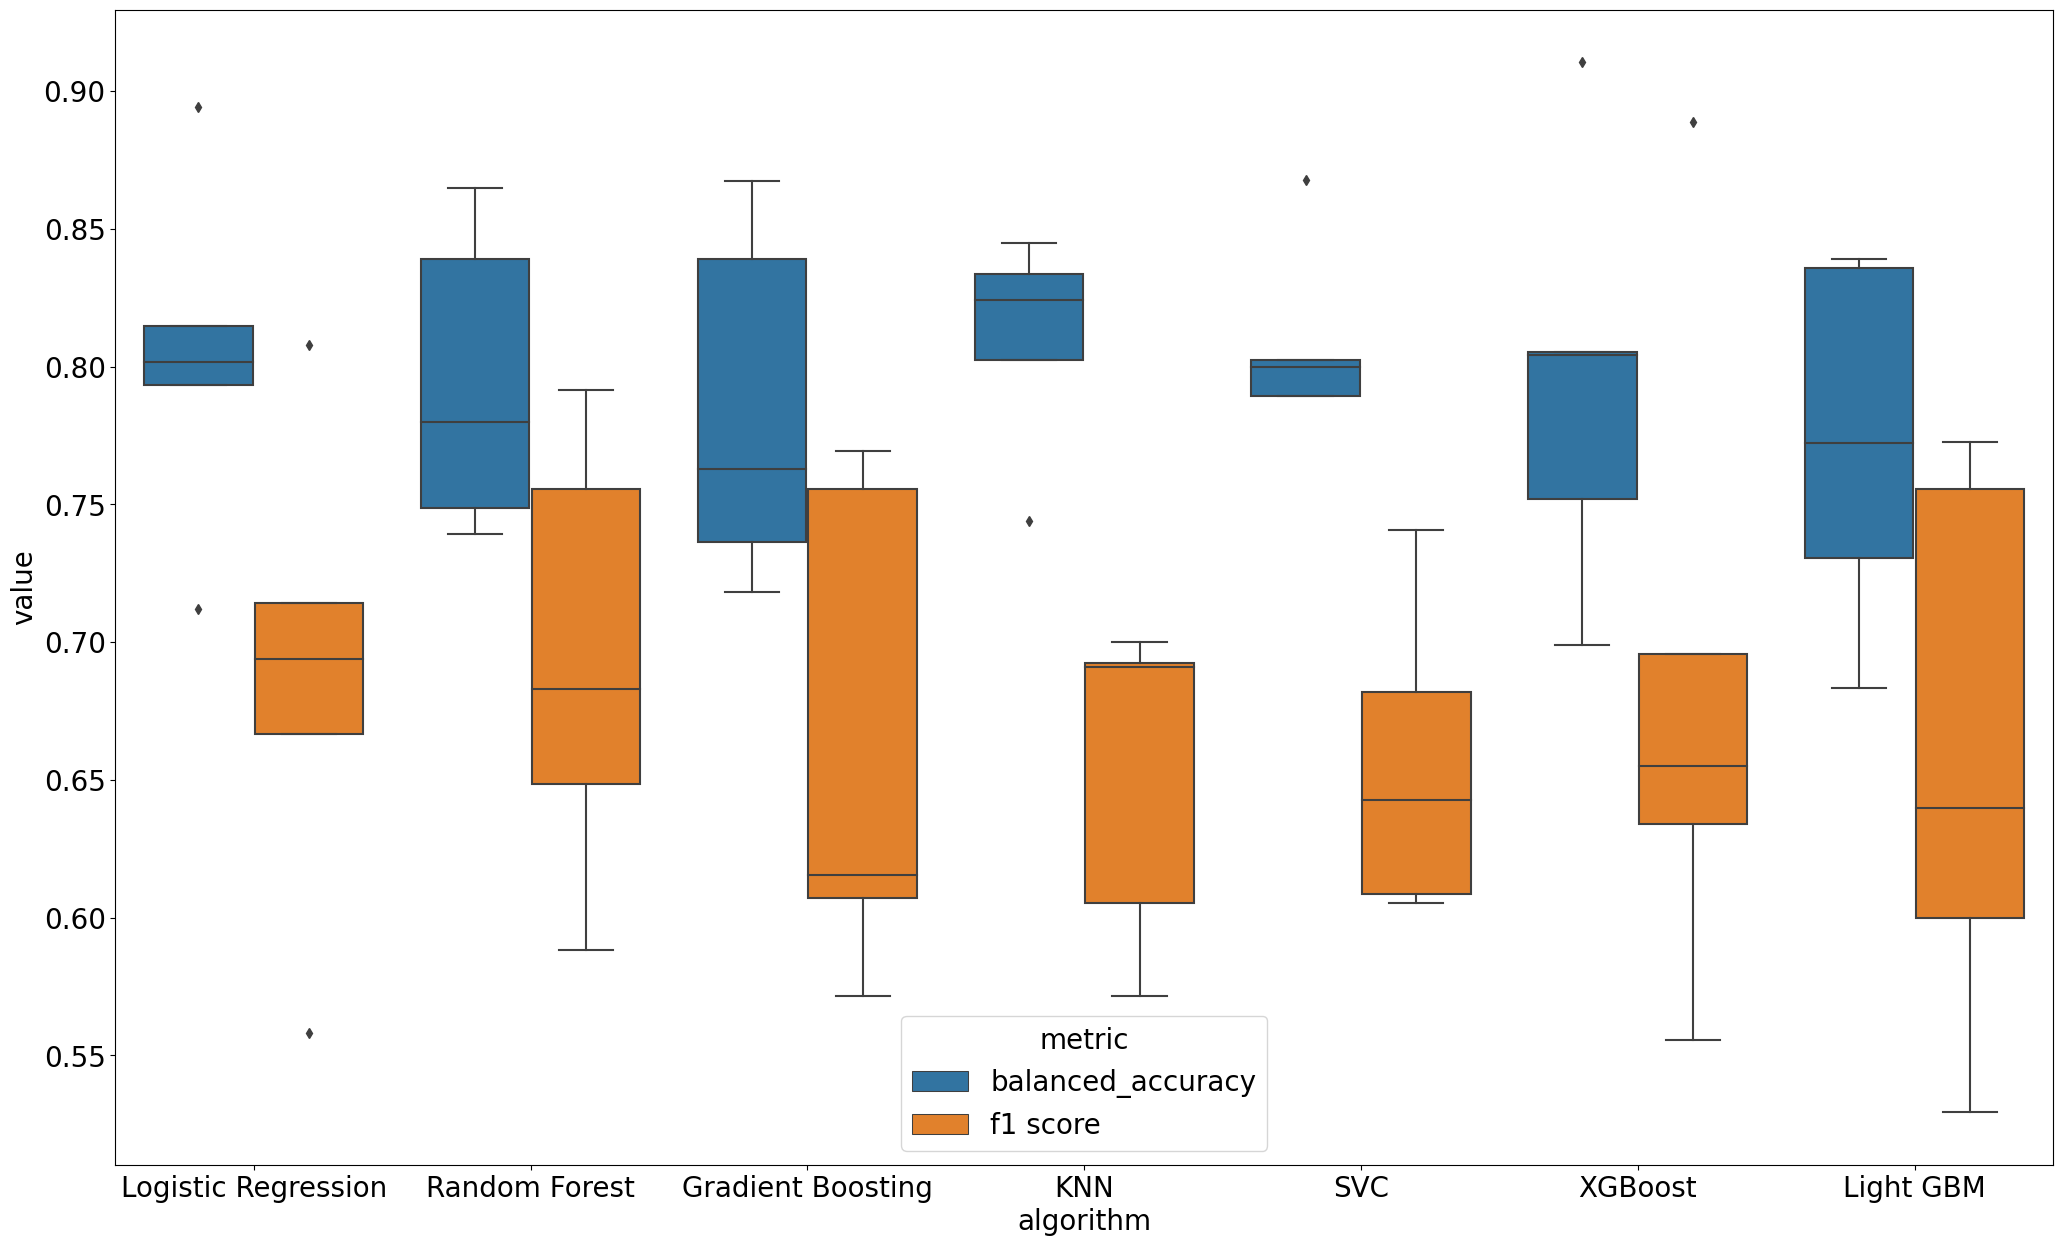

In [100]:
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="algorithm", y="value", data=melted, hue="metric", ax=ax, meanline=True)

Text(0, 0.5, '')

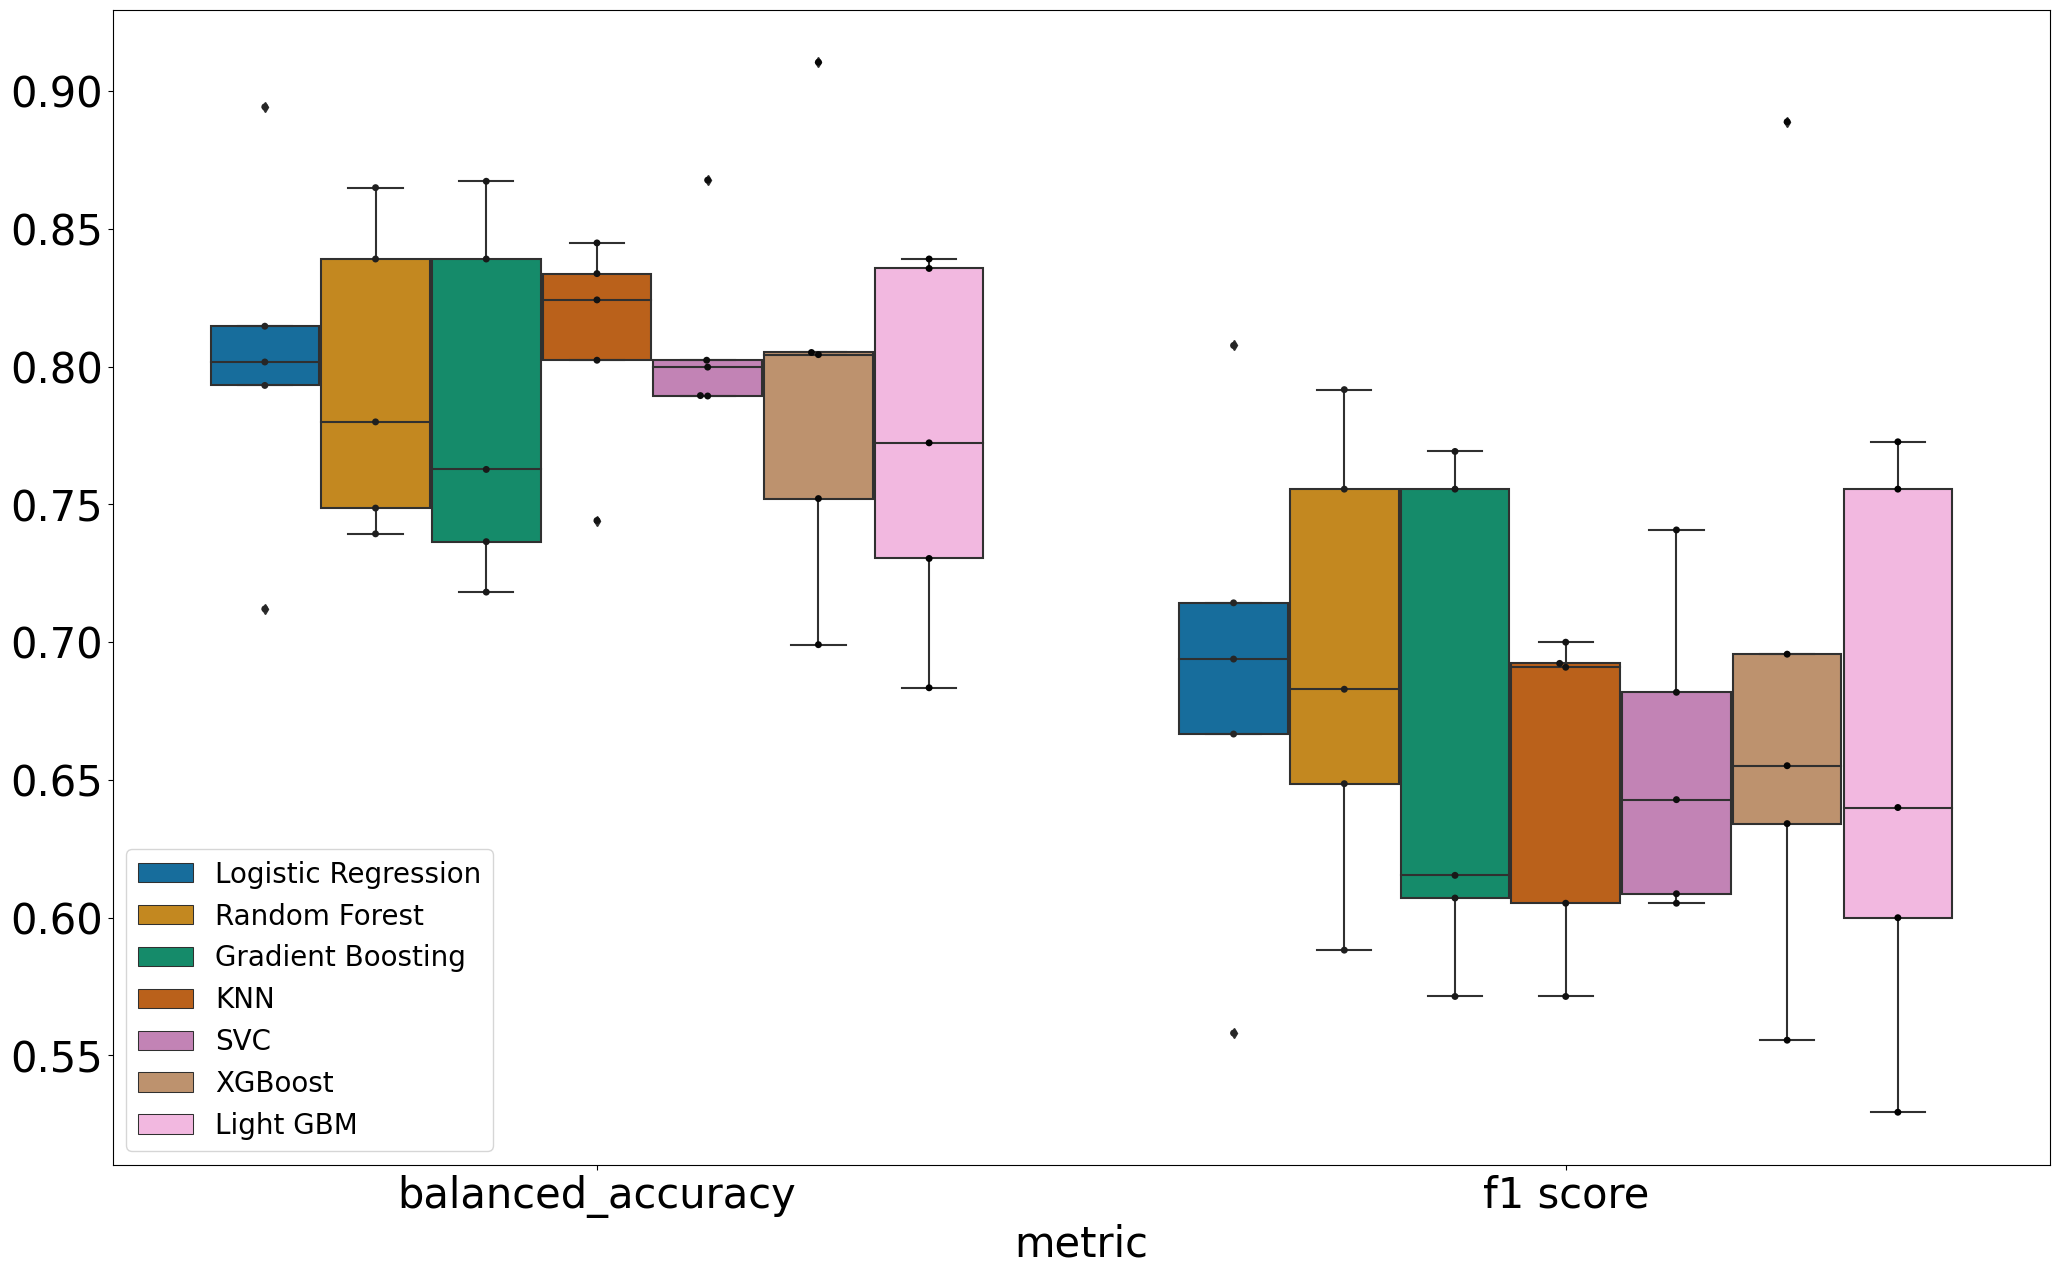

In [101]:
rcParams["font.size"] = 30
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, palette="colorblind")
sns.swarmplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, dodge=True, color="k")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:7], labels[:7], fontsize=20)
ax.set_ylabel(None)

In [102]:
fig.savefig("cv_res_rdkit_pca.pdf")

# PCA Analysis

In [31]:
pca = PCA(n_components=0.95)

In [32]:
xx = x
yy = y

In [33]:
scaler = StandardScaler()
xx = scaler.fit_transform(xx[descriptors_names])
oob_x = scaler.transform(oob_x[descriptors_names])

In [34]:
xx = pca.fit_transform(xx)
oob_x = pca.transform(oob_x)

In [35]:
loading_scores = pd.Series(pca.components_[0], index=descriptors_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
print(sorted_loading_scores[:20])

Chi0                   0.163975
HeavyAtomCount         0.163077
NumValenceElectrons    0.162670
Chi1                   0.161159
LabuteASA              0.159257
ExactMolWt             0.159153
MolWt                  0.158888
HeavyAtomMolWt         0.156989
Kappa1                 0.156626
Chi0v                  0.155506
Chi0n                  0.152757
Chi1v                  0.151610
MolMR                  0.150427
BertzCT                0.144233
Chi1n                  0.144046
Chi2v                  0.143743
Chi2n                  0.139733
Chi3n                  0.137446
NumHeteroatoms         0.130044
Chi3v                  0.128852
dtype: float64


In [36]:
loading_scores = pd.Series(pca.components_[1], index=descriptors_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
print(sorted_loading_scores[:20])

PEOE_VSA6              0.216285
MolLogP                0.193046
FpDensityMorgan1       0.178562
FpDensityMorgan2       0.160550
MaxPartialCharge       0.149015
MinAbsPartialCharge    0.147056
MaxAbsPartialCharge    0.140084
TPSA                   0.139976
NOCount                0.139368
Chi4n                  0.137543
VSA_EState7            0.136071
MinPartialCharge       0.132653
FpDensityMorgan3       0.132251
Chi4v                  0.125838
Chi3n                  0.124706
MaxEStateIndex         0.122780
MaxAbsEStateIndex      0.122780
Chi3v                  0.120462
SlogP_VSA5             0.118694
SMR_VSA5               0.117598
dtype: float64


In [37]:
loading_scores = pd.Series(pca.components_[2], index=descriptors_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
print(sorted_loading_scores[:20])

NumAromaticCarbocycles    0.259393
fr_benzene                0.259393
NumAromaticRings          0.258963
FractionCSP3              0.246520
VSA_EState6               0.234818
SMR_VSA7                  0.228367
SlogP_VSA6                0.225149
SMR_VSA5                  0.190688
RingCount                 0.185320
SlogP_VSA8                0.182090
SlogP_VSA5                0.168489
BCUT2D_LOGPLOW            0.139509
HallKierAlpha             0.138595
BertzCT                   0.138209
VSA_EState7               0.125283
VSA_EState8               0.124809
BCUT2D_MRLOW              0.124696
fr_unbrch_alkane          0.120142
NumRotatableBonds         0.117087
BalabanJ                  0.116928
dtype: float64


In [38]:
pca_df = pd.DataFrame(xx, columns=[f"PC{n}" for n in range(1, xx.shape[1]+1)])

In [39]:
rcParams["font.size"] = 20

Text(0, 0.5, 'summary % variance explained')

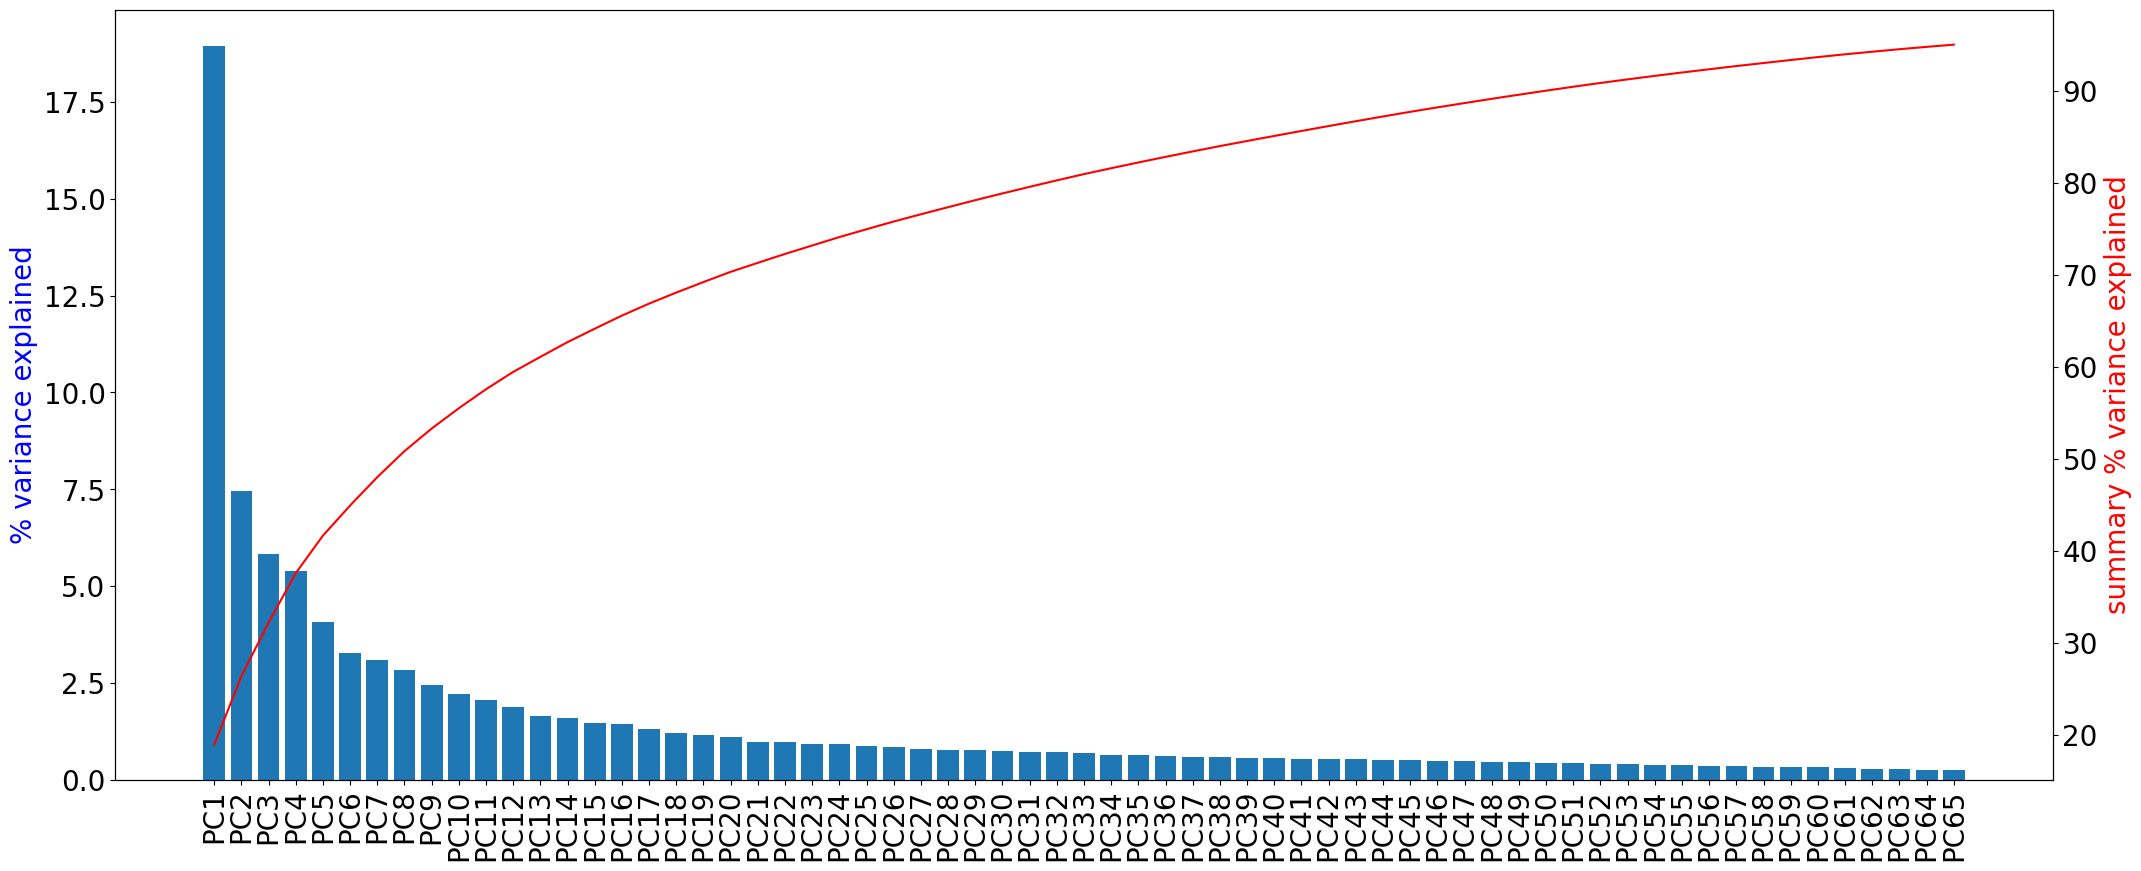

In [40]:
pcs = [f"PC{n}" for n in range(1, xx.shape[1]+1)]
fig, ax = plt.subplots(figsize=(25,10))
ax.bar(pcs, pca.explained_variance_ratio_*100)
ax.tick_params(axis="x", rotation=90)
ax2 = ax.twinx()
ax2.plot(pcs, (pca.explained_variance_ratio_*100).cumsum(), c="r")
ax.set_ylabel("% variance explained", color="b")
ax2.set_ylabel("summary % variance explained", color="r")

In [41]:
fig.savefig("scree_plot_rdkit.pdf")

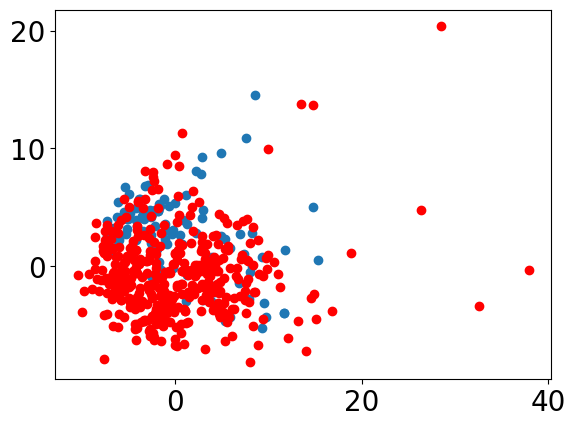

In [42]:
fig, ax = plt.subplots()
pca_df_ones = pca_df[(yy==1).values]
pca_df_zeros = pca_df[(yy==0).values]
ax.scatter(pca_df_ones["PC1"], pca_df_ones["PC2"])
ax.scatter(pca_df_zeros["PC1"], pca_df_zeros["PC2"], c="r")

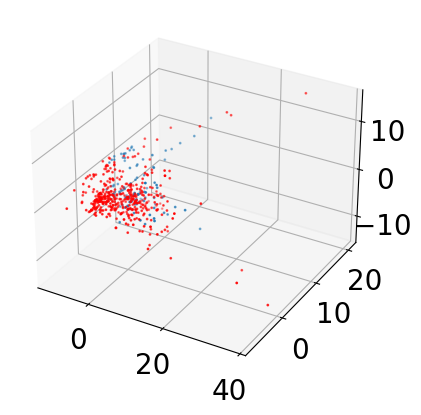

In [43]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.scatter(pca_df_ones["PC1"], pca_df_ones["PC2"], pca_df_ones["PC3"], s=1)
ax.scatter(pca_df_zeros["PC1"], pca_df_zeros["PC2"], pca_df_zeros["PC3"], c="r", s=1)

In [55]:
pd.concat([pca_df, yy.reset_index(drop=True)], axis=1).to_csv("pca_df_rdkit.csv")

# Mutual information

## No PCA

In [45]:
from sklearn.feature_selection import mutual_info_classif

In [46]:
minf = mutual_info_classif(dat3.iloc[:, 13:].fillna(0), dat3["class_encoded"], random_state=1, n_neighbors=3)

In [47]:
minf = pd.Series(minf, index=dat3.columns[13:])

In [48]:
minf.sort_values(ascending=False).head(40)

MolLogP                0.213090
MaxAbsPartialCharge    0.179414
MinPartialCharge       0.170223
PEOE_VSA6              0.153394
BCUT2D_MRLOW           0.150137
MaxAbsEStateIndex      0.145463
MaxEStateIndex         0.142870
LabuteASA              0.133674
MaxPartialCharge       0.129840
MolWt                  0.124614
MolMR                  0.124555
BCUT2D_MWHI            0.118469
HeavyAtomMolWt         0.116069
Chi0v                  0.113855
ExactMolWt             0.113061
EState_VSA9            0.112934
SMR_VSA7               0.108891
NumHAcceptors          0.103725
VSA_EState2            0.101046
TPSA                   0.100176
BCUT2D_MRHI            0.096419
VSA_EState10           0.093264
Chi1v                  0.093215
Kappa2                 0.092143
VSA_EState3            0.090658
HallKierAlpha          0.089557
MinAbsPartialCharge    0.089449
FpDensityMorgan1       0.088510
SlogP_VSA5             0.086357
SlogP_VSA2             0.085269
SMR_VSA10              0.084854
NOCount 

## PCA

In [52]:
minf = mutual_info_classif(pca_df, y, random_state=1, n_neighbors=3)

In [53]:
minf = pd.Series(minf, index=pca_df.columns)

In [54]:
minf.sort_values(ascending=False).head(40)

PC2     0.112967
PC1     0.085424
PC6     0.076649
PC3     0.071989
PC4     0.049853
PC9     0.048419
PC37    0.048412
PC12    0.048338
PC8     0.043910
PC5     0.042254
PC11    0.041878
PC14    0.041328
PC44    0.039602
PC10    0.038095
PC48    0.035803
PC39    0.033789
PC42    0.033535
PC13    0.032244
PC18    0.030212
PC29    0.029261
PC21    0.028873
PC28    0.025843
PC60    0.025162
PC23    0.025049
PC15    0.023838
PC16    0.022326
PC64    0.018212
PC57    0.017392
PC45    0.017243
PC34    0.016497
PC47    0.016317
PC40    0.016222
PC30    0.013162
PC31    0.012162
PC58    0.009469
PC20    0.009376
PC41    0.006853
PC61    0.006077
PC50    0.005977
PC46    0.005881
dtype: float64